Are innovation activities good export status predictors for firms in the developing world? This simple Machine Learnine project attempts to answer that question. Using Ecuadorian business-level data and using some export determinant features, I trained an export status (Exporter / Non exporter) supervised learning classifier.

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from statsmodels.discrete.discrete_model import Probit

## Import data

In [4]:
# Import data setting parameter 'convert_categoricals=False' to use values instead of labels.
dir = r'bdd_INN_2015.dta'
enai = pd.read_stata(dir, convert_categoricals=False) 

## Create useful functions

In [5]:
# Function to flatten dictionaries:
def flatten_dict(data_dict):
    """
    The function takes a dictionary as input, it iterates over the key-value pairs of the dictionary, and for each pair, it takes       the key and an item of the list value and adds them to a tuple. This tuple is then added to a list of tuples, which is returned     as the output of the function.
    
    Parameters:
    data_dict (dict): The input dictionary with key-value pairs where the value is a list of items.
    
    Returns:
    list: A list of tuples where each tuple contains a key from the input dictionary and one of its corresponding items from the         list value.
    
    Example:
    >>> data_dict = {'A':[1, 2], 'B':[3, 4], 'C':[5]}
    >>> flatten_dict(data_dict)
    [('A', 1), ('A', 2), ('B', 3), ('B', 4), ('C', 5)]
    """
    items = []
    for key, value_list in data_dict.items():
        for value in value_list:
            items.append((key, value))
    return items

# Function to replace values in pandas.Series
def replace_values_in_series(tuples_list, series):
    """
    The function takes a list of tuples and a pandas series as inputs. It iterates over the list of tuples comparing the second         value of each tuple with the values of the pandas series. When a match is found, the function replaces the value in the series       with the first value of the tuple. The modified series is then returned as the output of the function. This function can be         useful in cases where you have a set of values you want to replace in a pandas series and you have the replacement values in a       list of tuples.
    
    Parameters:
    tuples_list (list): A list of tuples, where each tuple contains a value to be replaced and a replacement value.
    series (pandas.core.series.Series): The input pandas series where the values will be replaced.
    
    Returns:
    pandas.core.series.Series: A pandas series where the values that match the first element of the tuples have been replaced by the     second element of the tuples.
    
    Example:
    >>> tuples_list = [('A', 1), ('B', 2), ('C', 3)]
    >>> series = pd.Series([1, 2, 3, 4, 5])
    >>> replace_values_in_series(tuples_list, series)
    0    A
    1    B
    2    C
    3    4
    4    5
    dtype: object
    """ 
    series = series.replace({x[1]: x[0] for x in tuples_list})
    return series

# Sums values through rows, ignoring NaN-like values
def sum_row_values(df: pd.DataFrame) -> pd.Series:
    """
    This function takes a pandas DataFrame as input and applies a lambda function to each row.
    The lambda function checks if all the values in the row are None, if they are it returns None.
    If there is at least one non-null value but not all, it returns the sum of non-null values.
    If there are no null values in the row, then the function returns the sum of all the values in that row.
    The function returns a pandas Series containing the sum of non-null values of all rows for which at least one non-null value is     present, None if all values are None, and the sum of all values of all rows for which there are no null values.

    Parameters:
    df (pd.DataFrame): DataFrame to be processed

    Returns:
    pd.Series: Series containing the sum of non-null values of rows for which at least one non-null value is present, None if all       values are None, and the sum of all values of all rows for which there are no null values.
    """
    result = df.apply(lambda x: None if x.isnull().all() else (x.sum(skipna=True) if x.isnull().any() else x.sum()), axis=1)
    return result

# Function to compute the Inverse Propensity Weighted (IPW) Causal Estimate for input data:
def ipw_causal_estimate(data, treatment, outcome, common_causes):
    """
    Compute the Inverse Propensity Weighted (IPW) Causal Estimate for input data.

    Parameters:
    data (pandas DataFrame): Data containing the treatment, outcome and common causes.
    treatment (string): Name of the column in data representing the binary treatment assignment.
    outcome (string): Name of the column in data representing the outcome variable.
    common_causes (list of strings): List of names of columns in data representing the common causes.

    Returns:
    float: IPW Causal Estimate.

    Raises:
    ValueError: If the input data does not meet the required specifications.

    Example:
    data = pd.read_csv("data.csv")
    treatment = "Treatment"
    outcome = "Outcome"
    common_causes = ["Cause1", "Cause2"]
    ipw_causal_estimate(data, treatment, outcome, common_causes)
    """
    # 1) Instantiate a CausalModel object:
    model = CausalModel(data=data, treatment=treatment, outcome=outcome, common_causes=common_causes)

    # 2) Identify causal effect and return target estimands:
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    # 3) Estimate the target estimand using a IPW:
    causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                                    method_name="backdoor.propensity_score_weighting",
                                                    target_units = "att",
                                                    method_params={"weighting_scheme":"ips_stabilized_weight"})
    # 4) Return IPW causal estimate:
    return causal_estimate_ipw.value

# Function to fit a probit regression model to the given data:
def get_probit_regression(X, y, var_weights=None, method=None, cov_type=None):
    """
    Fits a probit regression model to the given data.

    Parameters:
    -----------
    X : array-like
        The independent variables.
    y : array-like
        The dependent variable.
    var_weights : array-like or None, optional
        The weights for each observation. If None, equal weights are assumed.
    method : str or None, optional
        The optimization method to use. If None, the default optimization method 
        for the chosen family is used.
    cov_type : str or None, optional
        The type of covariance matrix estimator to use. If None, the default 
        estimator for the chosen family and optimization method is used.

    Returns:
    --------
    summary : str
        A summary of the fitted probit regression model.
    """
    # Create an instance of the probit link function
    probit_instance = probit()
    
    # Fit a generalized linear model with a binomial family and the probit link function
    probit_model = GLM(y, sm.add_constant(X),
                       var_weights=var_weights,
                       family=Binomial(link=probit_instance)
                      ).fit(method=method, cov_type=cov_type)
    
    # Return the summary of the fitted model
    return probit_model.summary()


## **Data cleaning**

In [6]:
enai['id_empresa'] = enai['id_empresa'].astype('str')

print('Starting sample: {} observations.'.format(enai.shape[0]))

Starting sample: 6275 observations.


In [7]:
# Check for duplicates:
print(str(enai.duplicated().sum()) + " duplicated rows found.")

0 duplicated rows found.


In [8]:
# a) Drop if employment == 0 along the entire period:
employment_vars =  ['ii_9_d_2012', 'ii_9_d_2013', 'ii_9_d_2014']
[enai.drop(enai[enai[col] == 0].index, inplace=True) for col in employment_vars]
# 218 rows dropped.

assert enai.shape[0] == 6057

In [9]:
# b) Drop if sales == 0:
sales_dict = {'ii_9_a_2012': 'sales_2012', 'ii_9_a_2013': 'sales_2013', 'ii_9_a_2014': 'sales_2014'}
enai = enai.rename(columns = sales_dict)
[enai.drop(enai[enai[col] == 0].index, inplace=True) for col in sales_dict.values()]
# 75 rows dropped.

assert enai.shape[0] == 5982

In [10]:
# c) Drop I+D expenditure outliers.

# c.1) Drop period-mean I+D, higher than $1,333,333 (too high) or between $0.5 and $100 (too low).
enai['id_mean'] = (enai['v_1_a_2012'] + enai['v_1_a_2013'] + enai['v_1_a_2014'] + enai['v_1_b_2012'] + enai['v_1_b_2013'] + enai['v_1_b_2014']) / 6
enai.drop(enai[(enai['id_mean'] >= 1333333) | (enai['id_mean'] < 100) & (enai['id_mean'] >= 0.5)].index, inplace=True) 
# 55 rows dropped

# c.2) Drop "other innovative" mean expenditures, higher than $ 15'000,000
enai['others_mean'] = (enai['v_4_total_2012'] + enai['v_4_total_2013'] + enai['v_4_total_2014']) / 3
enai = enai[enai['others_mean'] < 15000000] 
# 5 rows dropped.

# c.3) Drop I+D Intensity higher than 30% of period sales
enai['sales_mean'] = (enai['sales_2012'] + enai['sales_2013'] + enai['sales_2014']) / 3
enai['id_mean_div_sales_mean'] = enai['id_mean'] / enai['sales_mean']
enai = enai[enai['id_mean_div_sales_mean'] < 0.3] 
# 2 rows dropped.

assert enai.shape[0] == 5920

In [11]:
# d) Drop businesses with period-mean "fixed capital investment" as high as 5 times period-mean sales.
enai['fixed_cap_inv_mean'] = (enai['ii_9_c_2012'] + enai['ii_9_c_2013'] + enai['ii_9_c_2014'])/3
enai['k_inv_div_sales_mean'] = enai['fixed_cap_inv_mean'] / enai['sales_mean']
enai.drop(enai[enai['k_inv_div_sales_mean'] > 5].index, inplace=True)
# 1 row dropped.

assert enai.shape[0] == 5919

In [12]:
# e) Drop businesses with 95% or higher market share 
enai['sector_sales'] = enai.groupby('ciiu3')['sales_mean'].transform('sum')
enai['mkt_share'] = enai['sales_mean'] / enai['sector_sales']
enai.drop(enai[enai['mkt_share'] > 0.95].index, inplace=True)
# 25 rows dropped.

assert enai.shape[0] == 5894

####
This model includes seven individual sector dummy variables, aggregated according to R&D intensity. These variables take the value of 1 if the firm falls under a specific sector and 0 otherwise. The sectorial dummies include:

1. low-technology manufacturing industries
2. medium-low-technology manufacturing industries
3. medium-high-technology manufacturing industries
4. high-technology manufacturing industries
5. extractive industries
6. knowledge-intensive services industry
7. less knowledge-intensive services

The sectorial aggregation is based on the The International Standard Industrial Classification of All Economic Activities (ISIC) at two-digit level, as shown in the dictionary below.

In [13]:
# f) Create "Business Sector" categorical variable using ISIC2 classification:

sector_dict = {1: ["C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C31", "C32"],
               2: ["C19", "C23", "C24", "C25", "C33", "S95"],
               3: ["C20", "C22", "C27", "C28", "C29", "C30"],
               4: ["C21", "C26"],
               5: ["B05", "B06", "B07", "B08"],
               6: ["J58", "J59", "J60", "J61", "J62", "J63", "K64", "K65", "K66", "M69", "M70", "M71", "M72", "M74", "M75", "N80", "P85", "Q86", "Q87", "Q88", "R90", "R91", "R92", "R93"],
               7: ["B09", "G45", "G46", "G47", "H49", "H50", "H51", "H52", "H53", "I55", "I56", "L68", "M73", "N77", "N78", "N79", "N81", "N82", "O84", "S94", "S96", "T97", "T98", "U99"],
               8: ["F41", "F42", "F43"],
               9: ["D35", "E35", "E36", "E37", "E38", "E39"],
               10: ["A01", "A02", "A03"]
               }

In [14]:
# Use sector_list() and replace_values_in_series() functions:
enai['business_sector'] = replace_values_in_series(flatten_dict(sector_dict), enai['ciiu2'].copy())

# Drop businesses belonging to non-exporters sectors (8, 9, 10).
enai = enai[enai['business_sector'] < 8]
# 513 business belonging to non-exporters sectors 8 and 9 are dropped. Sector 10 has no samples.

# Convert 'business_sector' column into a categorical feature: 
enai['business_sector'] = enai['business_sector'].astype('category')

# Get dummy features from 'business_sector':
enai = pd.get_dummies(enai, columns = ['business_sector'], prefix = 'sector')

assert enai.shape[0] == 5381

In [15]:
# Final sample:
print('Final sample: {} observations.'.format(enai.shape[0]))

Final sample: 5381 observations.


## Feature engineering

#### Control variables

In [16]:
# 1. Work productivity as log of sales per employee:
enai['ln_prod_2012'] = np.log(enai['sales_2012'] / enai['ii_9_d_2012']) # Lagged productivity
enai['ln_prod_2014'] = np.log(enai['sales_2014'] / enai['ii_9_d_2014']) # Period productivity

# 2. Lagged size of the business as log of number of employees:
enai['ln_size_2012'] = np.log(enai['ii_9_d_2012'])

# 3. Lagged Fixed capital investment dummy: 1  1 for observations with 2012 fixed capital investment; 0 otherwise.
enai['fki_2012'] = 0
enai.loc[enai['ii_9_c_2012'] > 0, 'fki_2012'] = 1

# 4. Foreign Investment:  1 for observations with any foreign investment in period ('ii_4'); 0 otherwise.
enai['foreign_inv'] = 0
enai.loc[enai['ii_4'] > 0, 'foreign_inv'] = 1

In [17]:
# 5. Province cooperation variable:

# 5.1. Create a list of disagregated 'cooperation' variables.
alphabet_list = 'abcdefghij'
viii_2_list = ['viii_2_{}'.format(x) for x in alphabet_list]
    
# 5.2 Use sum_row_values() to create an unified 'cooperation' for innovation variable by adding all the disagregated ones. Then, turn 'cooperation' into a dummy variable. IMPORTANT: NaN are non-innovative firms (control group). 
enai['cooperation'] = sum_row_values(enai[viii_2_list])
enai.loc[enai['cooperation'] > 0, 'cooperation'] = 1

assert enai['cooperation'].mean() == 0.8556789069171649 

# 5.3 create 'province_coop', which is 'cooperation' mean-aggregated per province and the one used for further analysis.
enai['cooperation_2'] = enai['cooperation'].replace(np.nan, 0)
enai['province_coop'] = enai.groupby('cod_provincia')['cooperation_2'].transform('mean')

# 6. ID Investment: A dummy variable that indicates if a firm invested in I+D during 2012:
enai['id_2012'] = 0
enai.loc[(enai['v_1_total_2012']) > 0, 'id_2012'] = 1

# 7. Other innovation investment: A dummy variable that indicates if a firm invested in other innovation activities during 2012:
enai['other_inn_2012'] = 0
enai.loc[(enai['v_4_total_2012']) > 0, 'other_inn_2012'] = 1

# 8. Lagged export intensity (2012) is total exports over total sales.
enai['export_int_2012'] = enai['ii_9_b_2012'] / enai['sales_2012']

# 9. Lagged export propensity is a dummy variable of export intensity.
enai['export_prop_2012'] = 0
enai.loc[enai['export_int_2012'] > 0, 'export_prop_2012'] = 1

#### Target variables

In [18]:
# 10. Target export intensity (2014) is total exports over total sales
enai['export_int_2014'] = enai['ii_9_b_2014'] / enai['sales_2014']

# 11. Target export propensity (2014) is a dummy variable of export intensity.
enai['export_prop_2014'] = 0
enai.loc[enai['export_int_2014'] > 0, 'export_prop_2014'] = 1

#### Treatment variables

In [19]:
# 12. Innovation treatment: Indicates if a firm reports any innovation activity during 2012-2014. To do so, we take the 'cooperation' variable, because 0s and 1s are innovative businesses and NaN are non-innovatives.
enai['innovator'] = 0
enai.loc[~pd.isnull(enai['cooperation']), 'innovator'] = 1

assert enai['innovator'].mean() == 0.43523508641516445

# 13. 'Introducer' treatment: Indicates if an innovative business introduced any new or significatively improved product or process.
enai['introducer'] = np.nan
enai.loc[(enai['iii_1_a'] == 1) | (enai['iii_1_b'] == 1) | (enai['iv_1_a'] == 1), 'introducer'] = 1
enai.loc[(enai['iii_1_a'] == 0) & (enai['iii_1_b'] == 0) & (enai['iv_1_a'] == 0) & ~(pd.isnull(enai['viii_2_a'])), 'introducer'] = 0

assert enai['introducer'].mean() == 0.4816396242527754

#### Final DataFrames

In [20]:
# 14. Covariates (features) DataFrame. Note that sector_4 "high-technology manufacturing industries" is left behind, as it is the reference category in the propensity score computations.

covariates = ['ln_prod_2012', 'ln_size_2012', 'fki_2012', 'foreign_inv', 'province_coop', 'id_2012', 'other_inn_2012', 'sector_1', 'sector_2', 'sector_3', 'sector_4', 'sector_5', 'sector_6', 'sector_7']

X = enai[covariates]

# 15. Target variables.
y_intensity = enai['export_prop_2014']
y_propensity = enai['export_int_2014']

# 16. Complete DataFrame 
df = enai[['ln_prod_2012', 'ln_size_2012', 'fki_2012', 'foreign_inv', 'province_coop', 'id_2012', 'other_inn_2012', # covariates
           'export_int_2012', 'export_prop_2012', # lagged covariates
           'sector_1', 'sector_2', 'sector_3', 'sector_4', 'sector_5', 'sector_6', 'sector_7', # sectorial dummies
           'export_int_2014', 'export_prop_2014', # target variables 
           'innovator', 'introducer', # treatment variables
           'fexp' # factor of expansion
          ]]

# 16.1 'Innovator' treatment DataFrame
innov_df = df[['ln_prod_2012', 'ln_size_2012', 'fki_2012', 'foreign_inv', 'province_coop', # covariates
           'export_int_2012', 'export_prop_2012', # lagged covariates
           'sector_1', 'sector_2', 'sector_3', 'sector_4', 'sector_5', 'sector_6', 'sector_7', # sectorial dummies
           'export_int_2014', 'export_prop_2014', # target variables 
           'innovator', # treatment variable
            'fexp' # factor of expansion
              ]]

#16.2 'Introducer' treatment DataFrame.
intro_df = df[['ln_prod_2012', 'ln_size_2012', 'fki_2012', 'foreign_inv', 'province_coop', 'id_2012', 'other_inn_2012', # covariates
           'export_int_2012', 'export_prop_2012', # lagged covariates
           'sector_1', 'sector_2', 'sector_3', 'sector_4', 'sector_5', 'sector_6', 'sector_7', # sectorial dummies
           'export_int_2014', 'export_prop_2014', # target variables 
           'introducer', # treatment variables
           'fexp' # treatment variables
              ]].dropna() # 3039 non-innovator firms dropped, as they cannot be introducers.

#16.2.1 'Introducer' as integer type:
intro_df['introducer'] = intro_df['introducer'].astype('int')

assert intro_df['introducer'].mean() == 0.4816396242527754

## **Exploratory Data Analysis**

#### Covariates correlation heatmap

<Axes: >

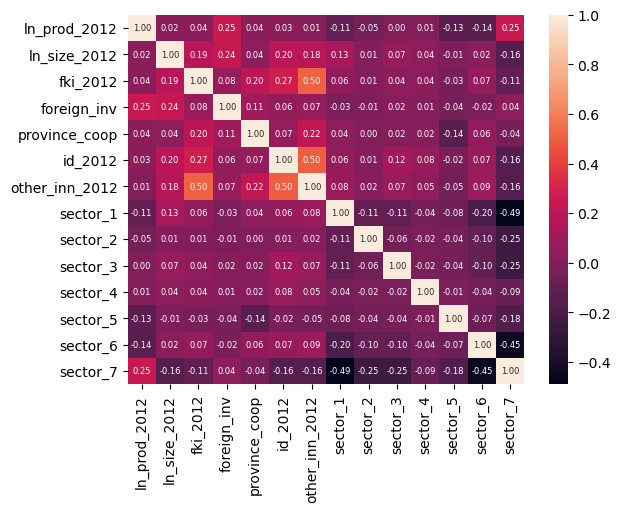

In [21]:
sns.heatmap(X.corr(), annot=True, fmt='.2f', annot_kws={'size': 6})

#### Export intensity comparison among innovators and non-innovators:

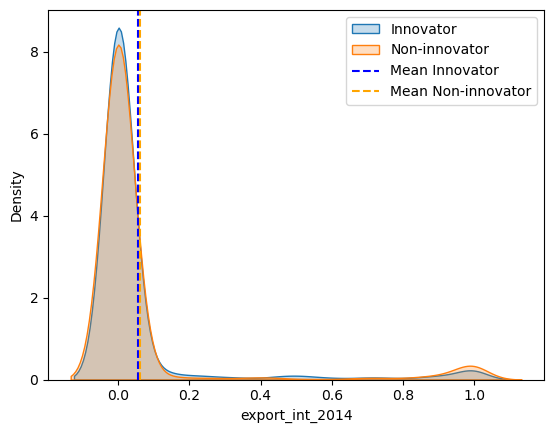

In [22]:
innovators_export_int = df.query('innovator == 1')['export_int_2014']
non_innovators_export_int = df.query('innovator == 0')['export_int_2014']

sns.kdeplot(innovators_export_int, shade=True, label = 'Innovator')
sns.kdeplot(non_innovators_export_int, shade=True, label='Non-innovator')

plt.axvline(x=innovators_export_int.mean(), color='blue', linestyle='--', label='Mean Innovator')
plt.axvline(x=non_innovators_export_int.mean(), color='orange', linestyle='--', label='Mean Non-innovator')

plt.legend()

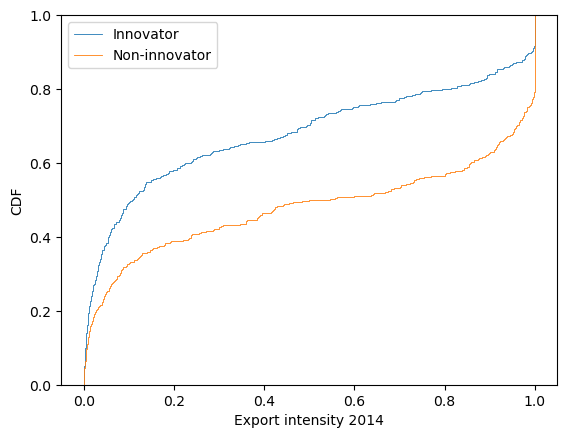

In [23]:
sns.ecdfplot(df.query('innovator == 1 & export_int_2014 !=0')['export_int_2014'], label='Innovator', linewidth=0.6)
sns.ecdfplot(df.query('innovator == 0 & export_int_2014 !=0')['export_int_2014'], label='Non-innovator', linewidth=0.6)

plt.xlabel('Export intensity 2014')
plt.ylabel('CDF')
plt.legend()
plt.show()

In [24]:
from scipy.stats import ttest_ind

# Difference of means test:
t, p = ttest_ind(innovators_export_int, non_innovators_export_int)

print("t-value:", t)
print("p-value:", p)

t-value: -1.0059355069049567
p-value: 0.31449184311501643


The t-value indicates the magnitude of the difference between the means of the two groups. Since the t-value is negative, it suggests that the average export intensity of innovative companies is lower than that of non-innovative companies. However, since the absolute value of t is less than 2, there is no statistically significant difference.

The p-value indicates the probability of obtaining a result at least as extreme as the observed one, if there is actually no difference between the groups. Since the p-value is greater than the threshold of 0.05, we cannot reject the null hypothesis that **there is no statistically significant difference in the export intensity between innovative and non-innovative companies**.

#### Productivity comparison between innovators and non-innovators:

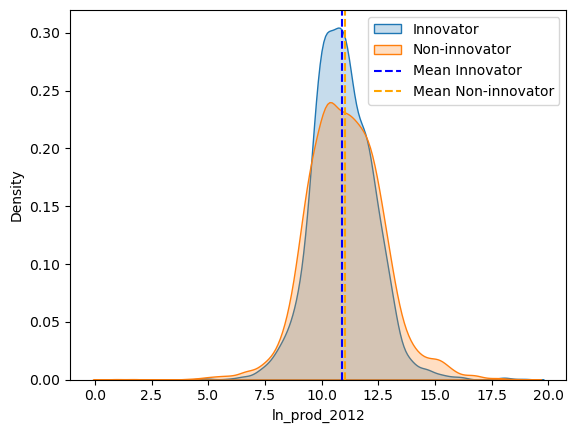

In [25]:
innovators_productivity = df.query('innovator == 1')['ln_prod_2012']
non_innovators_productivity = df.query('innovator == 0')['ln_prod_2012']

sns.kdeplot(innovators_productivity, shade=True, label = 'Innovator')
sns.kdeplot(non_innovators_productivity, shade=True, label='Non-innovator')

plt.axvline(x=innovators_productivity.mean(), color='blue', linestyle='--', label='Mean Innovator')
plt.axvline(x=non_innovators_productivity.mean(), color='orange', linestyle='--', label='Mean Non-innovator')

plt.legend()

In [26]:
# Difference of means test:
t, p = ttest_ind(innovators_productivity, non_innovators_productivity)

print("t-value:", t)
print("p-value:", p)

t-value: -2.481987673067039
p-value: 0.013095477344194861


The t-value sign suggests that non-innovative firms are more productive than the innovative ones. Since the p-value is smaller than the threshold of 0.05, the null hypothesis is rejected. Hence, **there is statistically significant difference in the productivity between innovative and non-innovative firms**.

#### Size comparison between innovators and non-innovators:

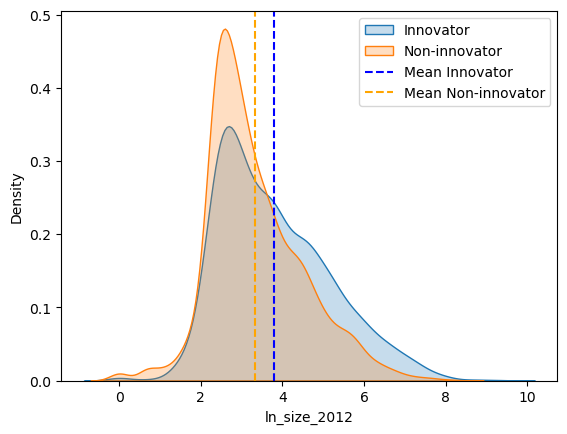

In [27]:
innovators_size = df.query('innovator == 1')['ln_size_2012']
non_innovators_size = df.query('innovator == 0')['ln_size_2012']

sns.kdeplot(innovators_size, shade=True, label = 'Innovator')
sns.kdeplot(non_innovators_size, shade=True, label='Non-innovator')

plt.axvline(x=innovators_size.mean(), color='blue', linestyle='--', label='Mean Innovator')
plt.axvline(x=non_innovators_size.mean(), color='orange', linestyle='--', label='Mean Non-innovator')

plt.legend()

In [28]:
# Difference of means test:
t, p = ttest_ind(innovators_size, non_innovators_size)

print("t-value:", t)
print("p-value:", p)

t-value: 13.680274205438584
p-value: 6.650693657280036e-42


The t-value sign indicates that innovative firms are larger than the non-innovatives. Since the p-value is much smaller than the threshold of 0.05, the null hypothesis is rejected. Hence, **there is statistically significant difference in size between innovative and non-innovative firms**.

## Propensity scores

#### 'Export propensity' propensity scores

'Innovator' treatment (y) export propensity PS:

In [30]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import probit

# Define covariates and target variables:
innovator_y = innov_df["innovator"]
innovator_prop_X = innov_df[['export_prop_2012', 'ln_prod_2012', 'fki_2012', 'ln_size_2012', 'foreign_inv',
                             'province_coop', 'sector_1', 'sector_2', 'sector_3', 'sector_5', 'sector_6', 'sector_7']] 

# Define weights variable:
var_weights = innov_df['fexp']

# Fit probit regression:
innov_export_prop_ps = get_probit_regression(innovator_prop_X, innovator_y,
                                       var_weights=var_weights,
                                       method='newton', cov_type="HC1")

# Print probit regression results:
print(innov_export_prop_ps)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              innovator   No. Observations:                 5381
Model:                            GLM   Df Residuals:                     5368
Model Family:                Binomial   Df Model:                           12
Link Function:                 probit   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -7860.3
Date:                Sun, 07 May 2023   Deviance:                       15721.
Time:                        20:19:41   Pearson chi2:                 1.44e+04
No. Iterations:                     2   Pseudo R-squ. (CS):             0.5154
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2406      0.411  

'Introducer' treatment (y) export propensity PS:

In [31]:
# Define covariates and target variables:
introducer_y = intro_df["introducer"]
introducer_prop_X = intro_df[['export_prop_2012', 'ln_prod_2012', 'fki_2012', 'ln_size_2012', 'foreign_inv',
                              'id_2012', 'other_inn_2012', 'province_coop', 'sector_1', 'sector_2', 'sector_3',
                              'sector_5', 'sector_6', 'sector_7']] 

# Define weights variable:
var_weights = intro_df['fexp']

# Fit probit regression:
intro_export_prop_ps = get_probit_regression(introducer_prop_X, introducer_y,
                                       var_weights=var_weights,
                                       method='newton', cov_type="HC2")

# Print probit regression results:
print(intro_export_prop_ps)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             introducer   No. Observations:                 2342
Model:                            GLM   Df Residuals:                     2327
Model Family:                Binomial   Df Model:                           14
Link Function:                 probit   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -4153.9
Date:                Sun, 07 May 2023   Deviance:                       8307.8
Time:                        20:19:51   Pearson chi2:                 6.18e+03
No. Iterations:                     2   Pseudo R-squ. (CS):            0.09827
Covariance Type:                  HC2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0335      0.466  

The results in the first table above show that, compared to non-innovative firms, innovative firms have a larger number of employees, a higher propensity to invest in fixed capital and to be located in regions with a higher level of technological cooperation.

On the other hand, when comparing firms that introduced new technologies and those that engaged in innovation activities but did not introduce new technologies, the only variable that is observably different is investment in R&D activities. In other words, firms that introduced new technologies to the market between 2012 and 2014 exhibit a higher propensity to invest in R&D. Moreover, the results for the introducing firm treatment reveal important differences among industries. 

## Principal Component Analysis

### Business export status with ML Classification Models

### Causality

#### Propensity score

Treatment effects under conditional independence

https://www.statsmodels.org/dev/examples/notebooks/generated/treatment_effect.html

statsmodels 0.14.0 no está disponible a 09/02/2023 en PiPy

#### https://www.pywhy.org/dowhy/v0.9.1/example_notebooks/dowhy_estimation_methods.html

In [39]:
from dowhy.causal_model import CausalModel

df = enai[['export_prop_2012', 'ln_prod_2012', 'ln_size_2012', 'fki_2012', 'foreign_inv', 'province_coop', 'id_2012', 'other_inn_2012', 'sector_1', 'sector_2', 'sector_3', 'sector_5', 'sector_6', 'sector_7', 'export_prop_2014', 'innovator']]

covariates = ['ln_prod_2012', 'ln_size_2012', 'fki_2012', 'foreign_inv', 'province_coop', 'id_2012', 'other_inn_2012', 'sector_1', 'sector_2', 'sector_3', 'sector_5', 'sector_6', 'sector_7']

treatments = ['innovator', 'introducer']
outcomes = {'export_prop_2014': 'export_prop_2012',
            'export_int_2014': 'export_int_2012'}

for treatment in treatments:
    for outcome, lagged_outcome in outcomes.items():
    
        # 1) Create especific input covariates list:
        cov_list = covariates.copy()
        cov_list.append(lagged_outcome)

        # Create especific input DataFrame:
        df = enai[cov_list + [outcome, treatment]]
         
        ipw_estimate = ipw_causal_estimate(data=df, treatment=treatments, outcome=outcomes, common_causes=cov_list)
        print(treatment + " effect on " + outcome + " is: " + str(round(ipw_estimate*100, 3)) + "%")

KeyError: "['introducer'] not in index"